#### Import libraries

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Concatenate files into one CSV

In [68]:
import glob

path = r'./Sales_Data' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
df.to_csv('full_sales_data.csv', index=False)

In [69]:
sales_data = pd.read_csv('full_sales_data.csv')
sales_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


#### Finding out dataset details

In [70]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186850 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 8.6+ MB


In [71]:
sales_data.isna().any()

Order ID            True
Product             True
Quantity Ordered    True
Price Each          True
Order Date          True
Purchase Address    True
dtype: bool

### Data Cleaning

#### Drop NA values

In [72]:
nan = sales_data[sales_data.isna().values.any(axis=1)]
display(nan.head())
sales_data.dropna(how='all', inplace=True)
display(sales_data.isna().any())

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
1,NaN,NaN,NaN,NaN,NaN,NaN
356,NaN,NaN,NaN,NaN,NaN,NaN
735,NaN,NaN,NaN,NaN,NaN,NaN
1433,NaN,NaN,NaN,NaN,NaN,NaN
1553,NaN,NaN,NaN,NaN,NaN,NaN


Order ID            False
Product             False
Quantity Ordered    False
Price Each          False
Order Date          False
Purchase Address    False
dtype: bool

#### Filter out extra column names resulting from joining CSV files

In [73]:
sales_data = sales_data[~sales_data['Order Date'].str.contains('Order')]
# Note: We do not get rid of other duplicate rows here. It could be the case that multiple of the same
#       product were ordered within the same order but were inputted as separate entries rather than being
#       accounted for in the "Quantity Ordered" column

#### Change column dtypes

In [74]:
sales_data['Quantity Ordered'] = pd.to_numeric(sales_data['Quantity Ordered'])
sales_data['Price Each'] = pd.to_numeric(sales_data['Price Each'])
sales_data['Order Date'] = pd.to_datetime(sales_data['Order Date'])
display(sales_data.dtypes)

Order ID                    object
Product                     object
Quantity Ordered             int64
Price Each                 float64
Order Date          datetime64[ns]
Purchase Address            object
dtype: object

### EDA

#### 1) Monthly sales breakdown

In [75]:
sales_data['Total Sales'] = sales_data['Quantity Ordered'] * sales_data['Price Each']
sales_data['Month'] = sales_data['Order Date'].dt.month
sales_data.groupby('Month').sum()

,Quantity Ordered,Price Each,Total Sales
Month,,,
1,10903,1.811768e+06,1.822257e+06
2,13449,2.188885e+06,2.202022e+06
3,17005,2.791208e+06,2.807100e+06
4,20558,3.367671e+06,3.390670e+06
5,18667,3.135125e+06,3.152607e+06
6,15253,2.562026e+06,2.577802e+06
7,16072,2.632540e+06,2.647776e+06
8,13448,2.230345e+06,2.244468e+06
9,13109,2.084992e+06,2.097560e+06


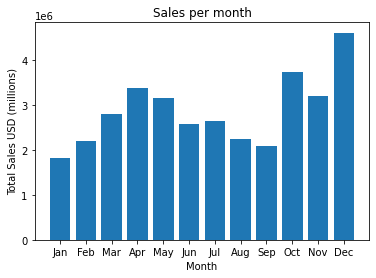

In [76]:
import calendar
labels = np.arange(1, 13, 1)
labels = list(map(lambda x: calendar.month_abbr[x], labels))
values = sales_data.groupby('Month').sum()['Total Sales']
plt.bar(labels, values)
plt.xlabel('Month')
plt.ylabel('Total Sales USD (millions)')
plt.title('Sales per month')
plt.show()

#### 2) Highest sales by city

In [77]:
sales_data['City'] = sales_data['Purchase Address'].str.split(',').str[1] + ", " + sales_data['Purchase Address'].str.split(',').str[2].str[1:3]
sales_data.head()
# Note: We need to include the State as well since two cities could have the same name

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Total Sales,Month,City
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",23.90,4,"Dallas, TX"
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",99.99,4,"Boston, MA"
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",600.00,4,"Los Angeles, CA"
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",11.99,4,"Los Angeles, CA"
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",11.99,4,"Los Angeles, CA"


In [78]:
sales_by_city = sales_data.groupby('City', as_index=False).sum().iloc[:, 0:4].sort_values('Total Sales', ascending=False).reset_index(drop=True)
sales_by_city

,City,Quantity Ordered,Price Each,Total Sales
0,"San Francisco, CA",50239,8.211462e+06,8.262204e+06
1,"Los Angeles, CA",33289,5.421435e+06,5.452571e+06
2,"New York City, NY",27932,4.635371e+06,4.664317e+06
3,"Boston, MA",22528,3.637410e+06,3.661642e+06
4,"Atlanta, GA",16602,2.779908e+06,2.795499e+06
5,"Dallas, TX",16730,2.752628e+06,2.767975e+06
6,"Seattle, WA",16553,2.733296e+06,2.747755e+06
7,"Portland, OR",11303,1.860558e+06,1.870732e+06
8,"Austin, TX",11153,1.809874e+06,1.819582e+06
9,"Portland, ME",2750,4.471893e+05,4.497583e+05


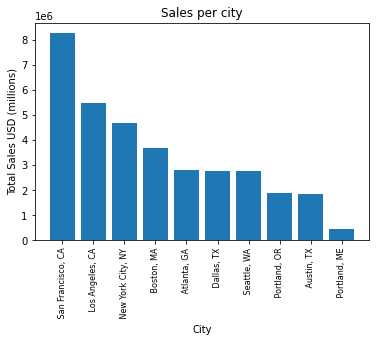

In [79]:
labels = sales_by_city['City']
values = sales_by_city['Total Sales']
plt.bar(labels, values)
plt.xticks(labels, rotation='vertical', size=8)
plt.xlabel('City')
plt.ylabel('Total Sales USD (millions)')
plt.title('Sales per city')
plt.show()

#### 3) Best time for advertisements

In [80]:
sales_data['Time of Purchase'] = sales_data['Order Date'].dt.hour
sales_data.groupby('Time of Purchase').count()['Quantity Ordered']

Time of Purchase
0      3910
1      2350
2      1243
3       831
4       854
5      1321
6      2482
7      4011
8      6256
9      8748
10    10944
11    12411
12    12587
13    12129
14    10984
15    10175
16    10384
17    10899
18    12280
19    12905
20    12228
21    10921
22     8822
23     6275
Name: Quantity Ordered, dtype: int64

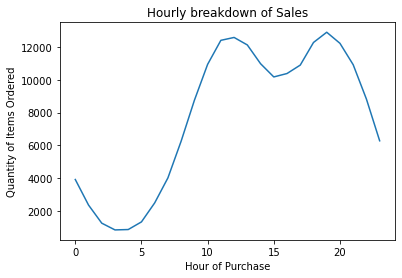

In [81]:
hours = np.arange(0, 24)
plt.plot(hours, sales_data.groupby('Time of Purchase').count()['Quantity Ordered'])
plt.xlabel('Hour of Purchase')
plt.ylabel('Quantity of Items Ordered')
plt.title('Hourly breakdown of Sales')
plt.show()

#### 4) Products that are commonly sold together

In [82]:
sales_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Total Sales,Month,City,Time of Purchase
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",23.90,4,"Dallas, TX",8
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",99.99,4,"Boston, MA",22
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",600.00,4,"Los Angeles, CA",14
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",11.99,4,"Los Angeles, CA",14
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",11.99,4,"Los Angeles, CA",9


In [83]:
# Get all the order ids where more than 1 unique item was ordered
multiple_items = sales_data[sales_data['Order ID'].duplicated(keep=False)]

# Make a new column with all unique products with the same order ID
multiple_items['Full Order'] = multiple_items.groupby('Order ID')['Product'].transform(', '.join)

# Drop duplicates on Order ID since we already have the column with all items in each order
multiple_items.drop_duplicates(subset='Order ID', inplace=True)

multiple_items.head()

<ipython-input-83-7630640cd61a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multiple_items['Full Order'] = multiple_items.groupby('Order ID')['Product'].transform(', '.join)
<ipython-input-83-7630640cd61a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multiple_items.drop_duplicates(subset='Order ID', inplace=True)


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Total Sales,Month,City,Time of Purchase,Full Order
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",600.00,4,"Los Angeles, CA",14,"Google Phone, Wired Headphones"
18,176574,Google Phone,1,600.00,2019-04-03 19:42:00,"20 Hill St, Los Angeles, CA 90001",600.00,4,"Los Angeles, CA",19,"Google Phone, USB-C Charging Cable"
30,176585,Bose SoundSport Headphones,1,99.99,2019-04-07 11:31:00,"823 Highland St, Boston, MA 02215",99.99,4,"Boston, MA",11,"Bose SoundSport Headphones, Bose SoundSport He..."
32,176586,AAA Batteries (4-pack),2,2.99,2019-04-10 17:00:00,"365 Center St, San Francisco, CA 94016",5.98,4,"San Francisco, CA",17,"AAA Batteries (4-pack), Google Phone"
119,176672,Lightning Charging Cable,1,14.95,2019-04-12 11:07:00,"778 Maple St, New York City, NY 10001",14.95,4,"New York City, NY",11,"Lightning Charging Cable, USB-C Charging Cable"


In [84]:
from itertools import combinations
from collections import Counter

count = Counter()

# Count the combinations of items in each row and store in count variable
for row in multiple_items['Full Order']:
    items = row.split(',')
    count.update(Counter(combinations(items, 2)))

# Convert from dictionary back to DataFrame
keys = []
values = []

for key in count.keys():
    keys.append(key)
    
for value in count.values():
    values.append(value)
    
count_frame = pd.DataFrame({'Items': keys, 'Count': values})
count_frame.sort_values(by='Count', inplace=True, ascending=False)
count_frame.reset_index(inplace=True, drop=True)
count_frame.head()

,Items,Count
0,"(iPhone, Lightning Charging Cable)",1005
1,"(Google Phone, USB-C Charging Cable)",987
2,"(iPhone, Wired Headphones)",447
3,"(Google Phone, Wired Headphones)",414
4,"(Vareebadd Phone, USB-C Charging Cable)",361


#### Top 10 pairings visualized

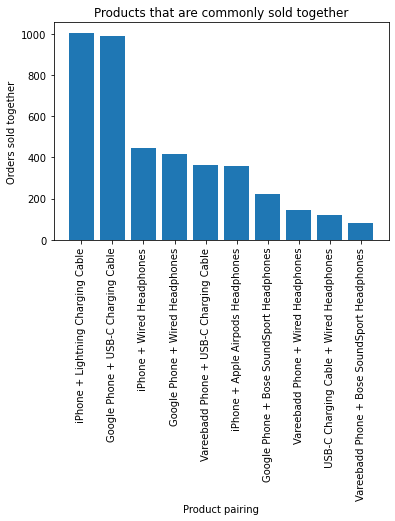

In [85]:
def addplus(tup):
    return tup[0] + ' +' + tup[1]

labels = count_frame['Items'][0:10].to_numpy()
val = count_frame['Count'][0:10].to_numpy()

count_frame['Items'] = count_frame['Items'].apply(addplus)

plt.bar(labels, val)
plt.xlabel('Product pairing')
plt.ylabel('Orders sold together')
plt.xticks(rotation=90)
plt.title('Products that are commonly sold together')
plt.show()

In [86]:
# Knowing which products are commonly sold together can be helpful for
# figuring out discounts/other incentives to increase sales.

#### 5) Most commonly sold products

In [87]:
most_common = sales_data.groupby('Product', as_index=False).sum()[['Product', 'Quantity Ordered']].sort_values(by='Quantity Ordered', ascending=False).reset_index(drop=True)
most_common.head()

,Product,Quantity Ordered
0,AAA Batteries (4-pack),31017
1,AA Batteries (4-pack),27635
2,USB-C Charging Cable,23975
3,Lightning Charging Cable,23217
4,Wired Headphones,20557


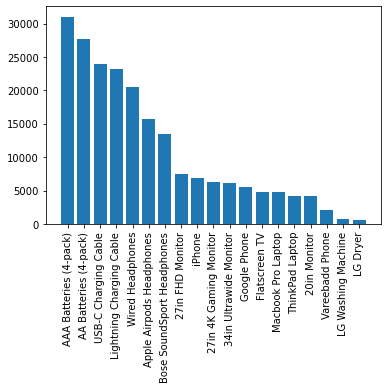

In [88]:
labels = most_common['Product']
values = most_common['Quantity Ordered']

plt.bar(labels, values)
plt.xticks(rotation=90)
plt.show()